Here we shall analyse stocks using Conv1d layer with window of 60 days and we shall do 10 days prediction. We shall follow the philosophy of WaveNet. Thanks to https://github.com/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb
# Imports

In [28]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt

In [29]:
df = pd.read_csv("../data/scalati.csv.gz")[:10000000][["uuid","user_minmax_steps"]] # I dati sono tanti, non ho una CUDA quindi non posso usarli tutti
df.head()

,uuid,user_minmax_steps
0,1003e58667235e01b49008155604980b3900b00e,0.169272
1,1003e58667235e01b49008155604980b3900b00e,0.239404
2,1003e58667235e01b49008155604980b3900b00e,0.013856
3,1003e58667235e01b49008155604980b3900b00e,0.284364
4,1003e58667235e01b49008155604980b3900b00e,0.123650


In [30]:
df.dropna(inplace=True) # Magari sui si potrebbe trovare un altro modo

Adesso l'obiettivo è quello di addestrare una rete neurale convoluzionale sulle sequenze di passi degli utenti. Per farle apprendere i vari pattern dirò alla rete di cercare di prevedere l'elemento n+1 della sequenza in funzione dei precedenti n elementi

In [31]:
xtrain = []
ytrain = []
xtest=[]
ytest=[]
window=50 # Gli n elementi della sequenza che darò in pasto alla rete
test_ratio=0.1 # La percentuale di elementi da usare per il testing
for uuid, group in df.groupby('uuid')["user_minmax_steps"]:
    split=int(len(group)*(1-test_ratio)) # Fino a "split" le finestre saranno usate per il training, poi per il test
    if split<window:
        continue
        
    group = np.array(group.values)


    for i in range (window,split): # Le sequenze sono fatte con una sliding window: Del tipo [1,2,3],[2,3,4],[4,5,6],...
        xtrain.append(group[i-window:i])
        ytrain.append(group[i]) # Deve prevedere l'elemento n+1

    for i in range (split,len(group)):
        xtest.append(group[i-window:i])
        ytest.append(group[i])

# Sistemo gli array in modo che vadano bene alla rete neurale
xtrain=np.array(xtrain).reshape(-1,window,1)
ytrain=np.array(ytrain).reshape(-1,1)
xtest=np.array(xtest).reshape(-1,window,1)
ytest=np.array(ytest).reshape(-1,1)

Ci sono vari modi di definire la rete neurale più adatta, c'è molto da sperimentare e dopo alcuni tentativi questa sembra una configurazione abbastanza ragionevole.

In [32]:
inputs = keras.Input(shape=xtrain[0].shape)
conv1d_1=keras.layers.Conv1D(filters=20, kernel_size=2, activation="relu", dilation_rate=1, padding="causal")(inputs)
conv1d_2=keras.layers.Conv1D(filters=20, kernel_size=2, activation="relu", dilation_rate=2, padding="causal")(conv1d_1)
conv1d_3=keras.layers.Conv1D(filters=20, kernel_size=2, activation="relu", dilation_rate=4, padding="causal")(conv1d_2)
conv1d_4=keras.layers.Conv1D(filters=20, kernel_size=2, activation="relu", dilation_rate=8, padding="causal")(conv1d_3)
conv1d_5=keras.layers.Conv1D(filters=10, kernel_size=1, padding="causal")(conv1d_4)
flatten = keras.layers.Flatten()(conv1d_5)
output = keras.layers.Dense(1, activation='sigmoid')(flatten)

model=keras.Model(inputs=inputs, outputs=output)
model.compile(loss=keras.losses.MeanAbsoluteError())
model.summary()

#L'ho definita secondo l'API funzionale di Keras, in modo da poter estrarre le attivazioni dei layer intermedi con facilità

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 50, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 50, 20)         │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 50, 20)         │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 50, 20)         │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 50, 20)         │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 50, 10)         │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           501 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,231 (12.62 KB)

 Trainable params: 3,231 (12.62 KB)

 Non-trainable params: 0 (0.00 B)

Addestriamo la rete...

In [33]:
from keras.src.callbacks import EarlyStopping

history = model.fit(xtrain, ytrain, epochs=20, verbose=1, batch_size=32, validation_split=.2, callbacks=EarlyStopping(patience=5))

Epoch 1/20
33190/33190 ━━━━━━━━━━━━━━━━━━━━ 74s 2ms/step - loss: 0.1263 - val_loss: 0.1237
Epoch 2/20
33190/33190 ━━━━━━━━━━━━━━━━━━━━ 71s 2ms/step - loss: 0.1236 - val_loss: 0.1237
Epoch 3/20
33190/33190 ━━━━━━━━━━━━━━━━━━━━ 73s 2ms/step - loss: 0.1233 - val_loss: 0.1237
Epoch 4/20
33190/33190 ━━━━━━━━━━━━━━━━━━━━ 74s 2ms/step - loss: 0.1233 - val_loss: 0.1244
Epoch 5/20
33190/33190 ━━━━━━━━━━━━━━━━━━━━ 76s 2ms/step - loss: 0.1231 - val_loss: 0.1246
Epoch 6/20
33190/33190 ━━━━━━━━━━━━━━━━━━━━ 73s 2ms/step - loss: 0.1229 - val_loss: 0.1247
Epoch 7/20
33190/33190 ━━━━━━━━━━━━━━━━━━━━ 73s 2ms/step - loss: 0.1230 - val_loss: 0.1237


La curva del training error va bene, quella del validation error ha parecchia varianza ma per ora va bene così

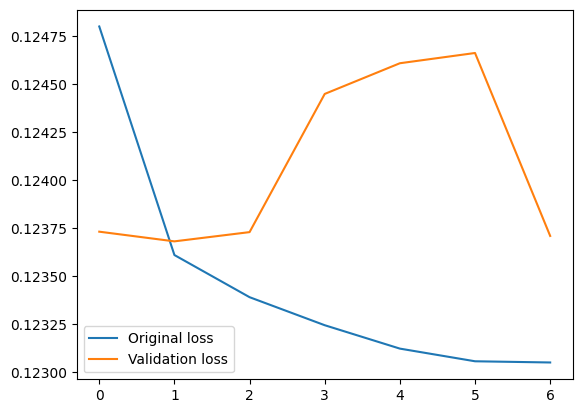

In [34]:
plt.plot(history.history['loss'], label='Original loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [37]:
model.evaluate(xtest, ytest, batch_size=32)

6574/6574 ━━━━━━━━━━━━━━━━━━━━ 6s 911us/step - loss: 0.1238


0.12374411523342133

In [38]:
model.save("../models/modello-passi.keras")

Questa parte serve a visualizzare le abilità di forecasting della rete. È un loop che continua a girare a lungo quindi va fermato a mano.
La parte blu è l'intera sequenza di passi dell'utente, la parte verde è la predizione della rete (fatta iterativamente basandosi su una sorta di sliding window finché non ci sono più dati "reali") sull'andamento dei passi e quella rossa è l'andamento reale.
La qualità delle previsioni sembra ragionevole, anche considerando che lo scopo era solamente apprendere i pattern e non fare il forecasting.

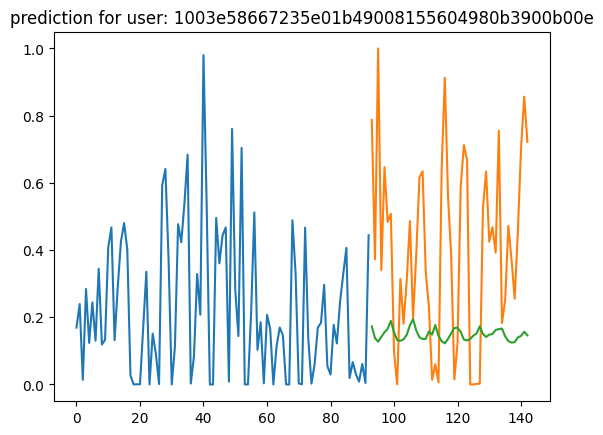

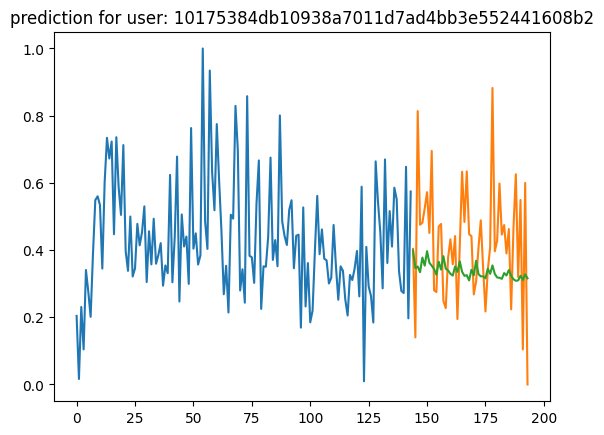

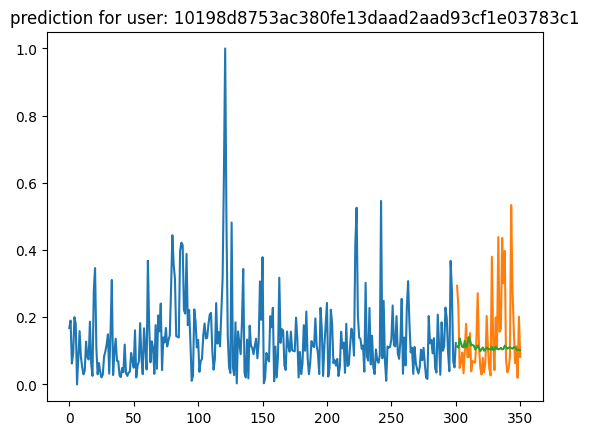

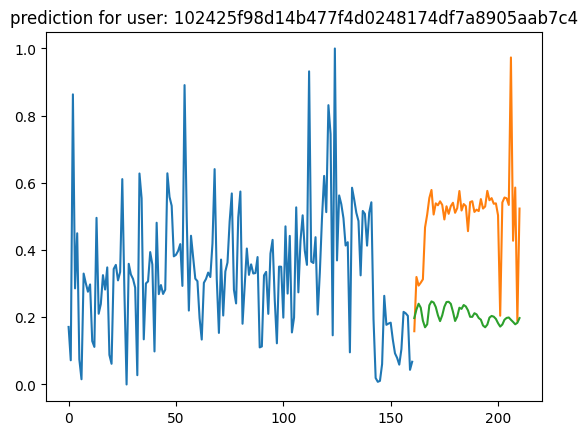

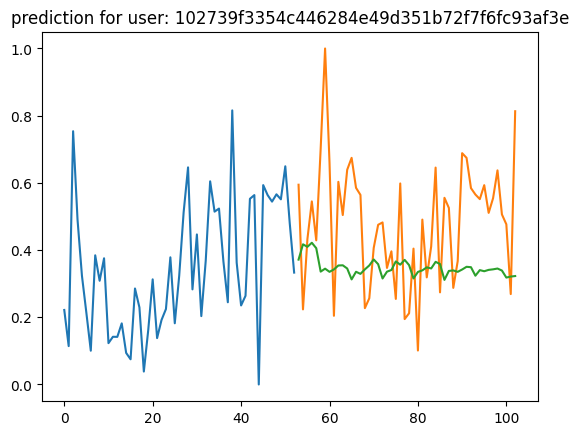

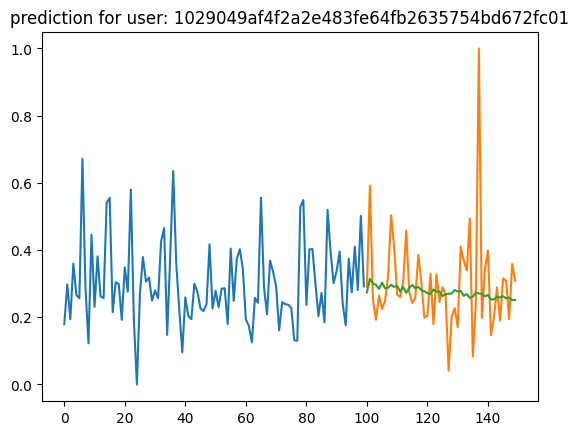

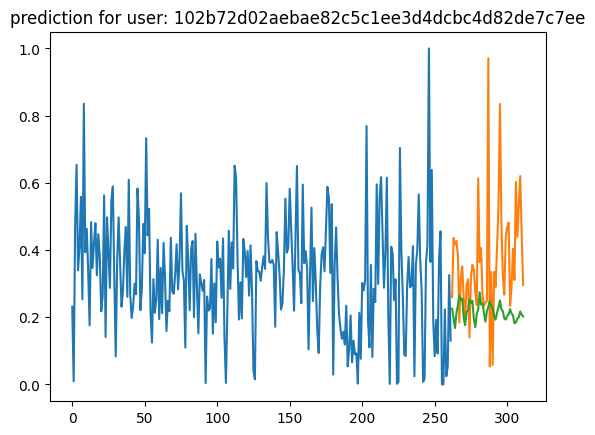

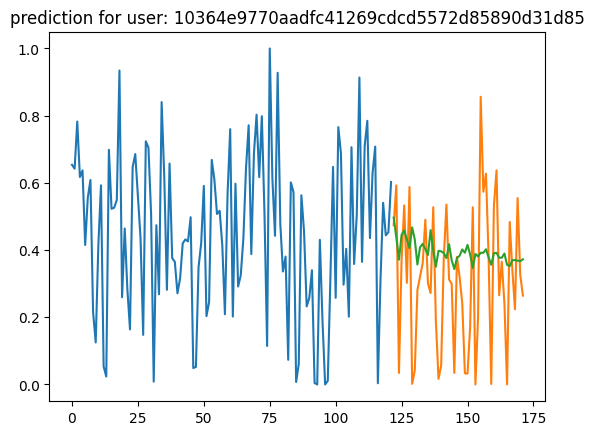

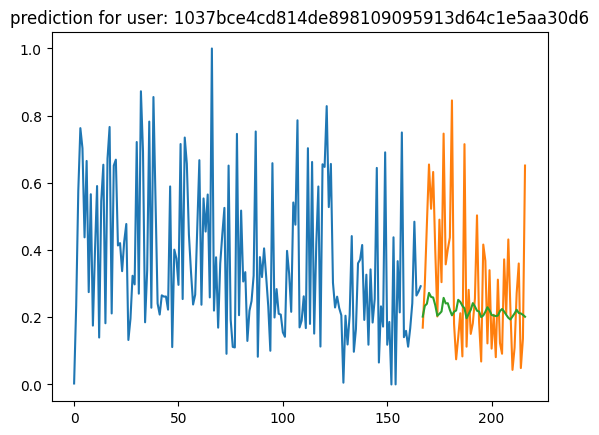

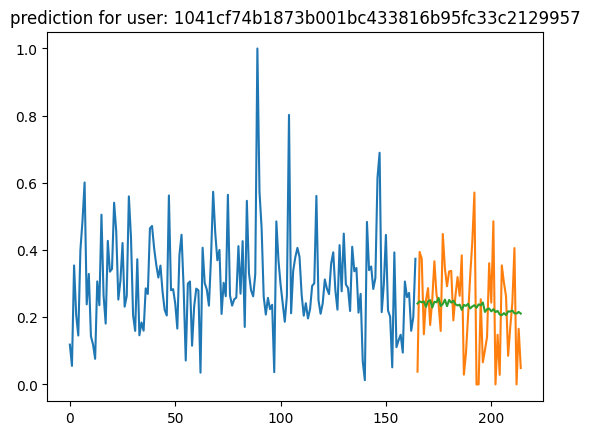

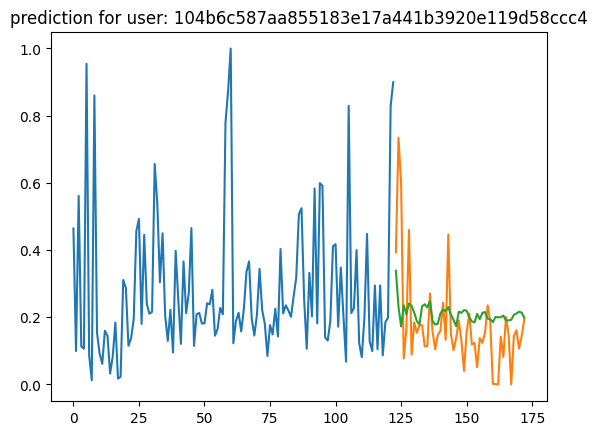

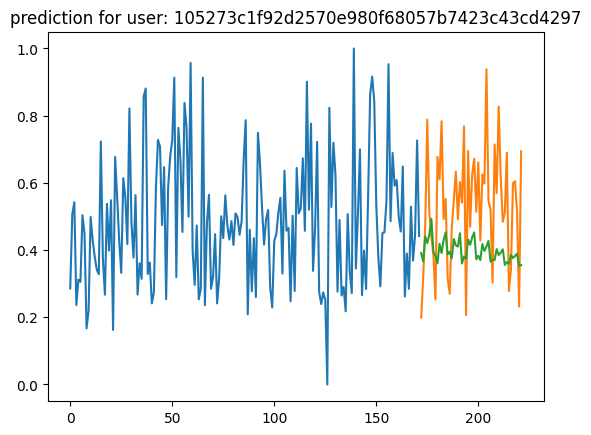

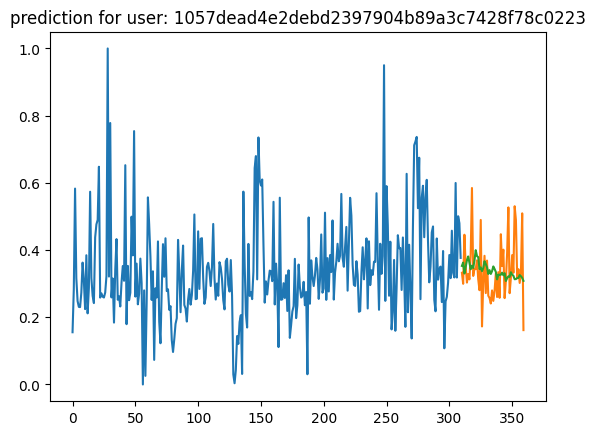

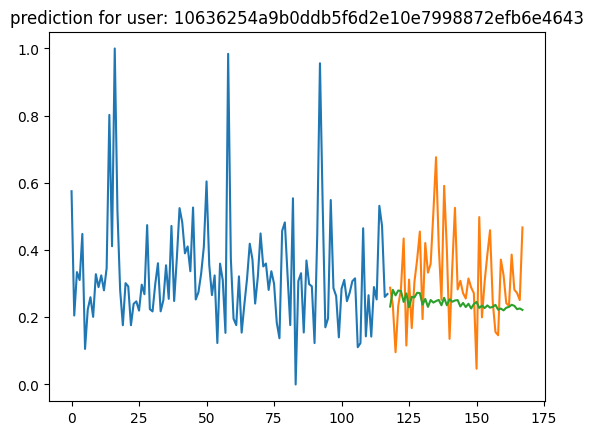

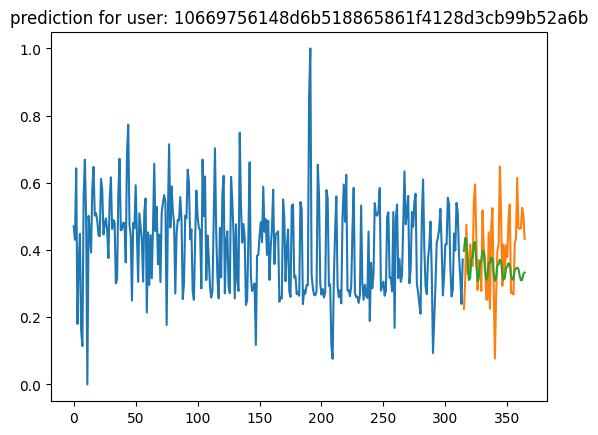

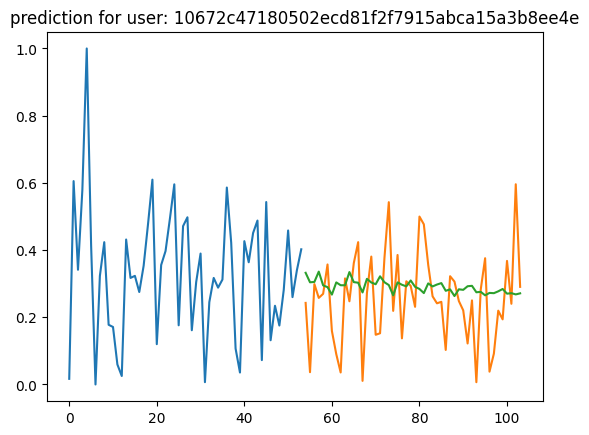

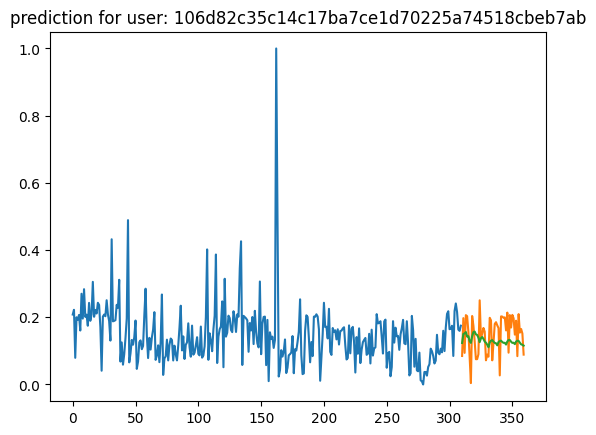

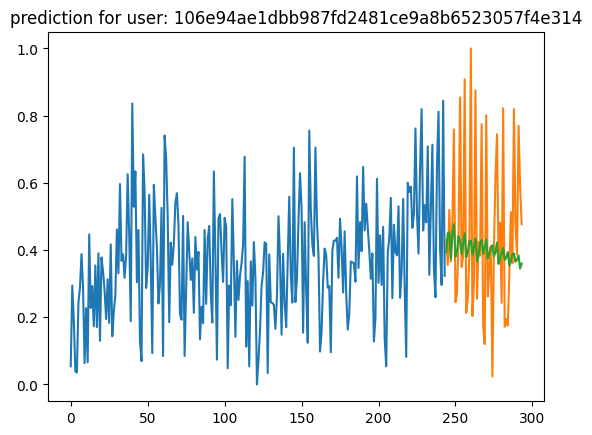

KeyboardInterrupt: 

In [39]:
for uuid,group in df.groupby('uuid')["user_minmax_steps"]:
    if len(group)<2*window:
        continue
    common = group.values
    actual=group[-window:].values
    pred=[]
    common=common[:-window]
    dati=common[-window:]
    for i in range(window):
        new_entry=[
            model.predict(np.array([dati]),verbose=0)[0][0]
        ]
        pred.append(new_entry)
        dati = np.concatenate((dati, new_entry))[-window:]
    pred=np.array(pred)
    plt.title("prediction for user: "+uuid)
    plt.plot([i for i in range(len(common))],common, label='Truth')
    plt.plot([i+len(common) for i in range(len(actual))],actual,label='Actual')
    plt.plot([i+len(common) for i in range(len(pred))],pred,label='Predicted')
    plt.show()
    plt.close()
